In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [0]:
def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

def pre_process_mag(dataset):
    mag = np.zeros(dataset.shape)
    phase = np.zeros(dataset.shape)
    x= 0
    for i in range(0,dataset.shape[0]):
      mag[i,:,:],phase[i,:,:] = compute_mag_phase(dataset[i])
    return mag,phase


def reconstructAll(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[i,:,:],ang[i,:,:])
    return recon

In [0]:
import random
import numpy as np
np.random.seed(100)
noise_mag = np.random.uniform(size = (32,32,3),low = 0.0, high = 7.0)

const_mag = np.full((32, 32, 3), 1.2)

In [4]:
# the data, shuffled and split between train and val sets
# Here we are using the official test set as our validation set, in further
# tutorials, test and validation splits will be explained properly.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(x_train.shape[1:]))
print('Total number of training samples: {0}'.format(x_train.shape[0]))
print('Total number of test samples: {0}'.format(x_test.shape[0]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the image
x_train /= 255
x_test /= 255

print(x_train.shape)

y_train_class = np_utils.to_categorical(y_train, 10)
y_test_class = np_utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 2s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of test samples: 10000
(50000, 32, 32, 3)


In [0]:
def reconstructPhase(mag, ang):
    recon = np.zeros(ang.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag,ang[i,:,:])
    return recon

In [0]:
dc, x_train_phase = pre_process_mag(x_train)
del dc
dc, x_test_phase = pre_process_mag(x_test)
del dc

In [7]:
print(x_train_phase.shape)
print(const_mag.shape)

(50000, 32, 32, 3)
(32, 32, 3)


In [0]:
x_train_recon_phase = reconstructPhase(const_mag,  x_train_phase)
del x_train_phase
x_test_recon_phase = reconstructPhase(const_mag,  x_test_phase)
del x_test_phase

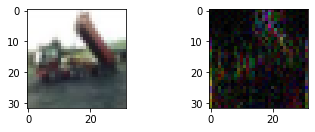

In [9]:
import matplotlib.pyplot as plt

plt.subplot(221)
plt.imshow(x_train[2])
plt.subplot(222)
plt.imshow(x_train_recon_phase[2])


In [10]:

model = Sequential()
#####################################################################
model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
######################################################################
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
######################################################################
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
######################################################################
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
######################################################################
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [11]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

opt = RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, y_train_class,validation_split=0.2, batch_size=32, epochs=50,callbacks=[early_stopping])

score = model.evaluate(x_test, y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9562 - accuracy: 0.2769 - val_loss: 1.7464 - val_accuracy: 0.3756
Epoch 2/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6585 - accuracy: 0.3936 - val_loss: 1.6073 - val_accuracy: 0.4107
Epoch 3/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5005 - accuracy: 0.4512 - val_loss: 1.3801 - val_accuracy: 0.5005
Epoch 4/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3976 - accuracy: 0.4893 - val_loss: 1.3300 - val_accuracy: 0.5197
Epoch 5/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3102 - accuracy: 0.5273 - val_loss: 1.2085 - val_accuracy: 0.5662
Epoch 6/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.2282 - accuracy: 0.5616 - val_loss: 1.1995 - val_accuracy: 0.5679
Epoch 7/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1594 - accuracy: 0.5870 - val_loss: 1.1058 - val_accuracy:

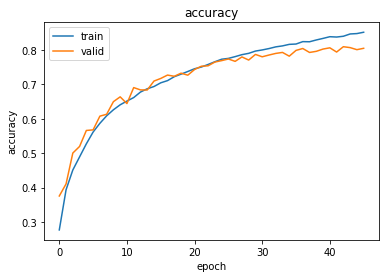

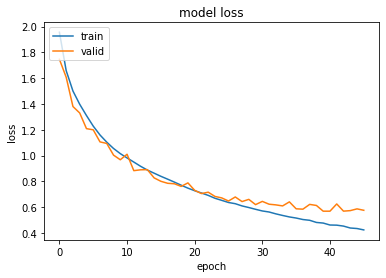

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [13]:
score = model.evaluate(x_test_recon_phase, y_test_class, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.5871458053588867
Test accuracy: 0.15209999680519104
